## Constructing a Synthetic NMR Well-log using Machine Learning

### Final Project for PGE 383 – Subsurface Machine Learning 

### Abhishek Bihani

Summary: The nuclear magnetic resonance (NMR) log is a useful tool to understand lithological information such as the variation of pore size distribution with depth, but it may not be measured in all wells. 

The project attempts to construct a missing well log from other available well logs, more specifically an NMR well log  from the measured Gamma Ray (GR), Caliper, Resistivity logs and the interpreted porosity from a well at the Keathley Canyon in the Gulf of Mexico. 

First, initial analysis is conducted on the well logs, followed by feature ranking. Thereafter, the logs are processed and polynomial regression modeling is conducted. The constructed model is then used to predict the NMR log  at Walker Ridge in Gulf of Mexico, which is another nearby site of methane hydrate accumulation. 

The workflow has been adapted from the Dr. Michael Pyrcz's [Subsurface Machine Learning course](https://github.com/GeostatsGuy/SubsurfaceMachineLearning) and my [Master's research thesis](https://www.pge.utexas.edu/images/pdfs/theses16/bihani.pdf)





### Inital analysis

First all the packages required for the workflow are imported

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
from pandas import DataFrame
import pandas.plotting as pd_plot           # matrix scatter plots
import scipy
from scipy import linalg                  # for linear regression
from scipy import stats                   # summary statistics
#import math                               # trigonometry etc.
#import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression           # linear regression with scikit learn
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split        # train and test split
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
import statsmodels.api as sm
#normalization for clustering
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

The working directory is set to the address where data is located and the well logs for Keathley Canyon are imported

In [2]:
df = pd.read_csv(r'C:\Users\Abhishek\Desktop\python regression\KC151_logs.csv')
#Looking at the data
df.head(n=10)

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
0,4.1388,91.765125,0.792482,26.577798,0.6812,1.996562,0.865698
1,4.2912,91.795654,0.792422,26.159968,0.6826,1.932333,0.866630
2,4.4436,93.512601,0.793198,25.914604,0.6819,1.968189,0.865522
3,4.5960,95.042114,0.785680,26.548334,0.7107,1.977933,0.865478
4,4.7484,94.909526,0.781504,27.045920,0.7157,1.937783,0.866366
5,4.9008,96.206315,0.782697,26.815796,0.6928,1.956473,0.865721
6,5.0532,101.210934,0.785442,27.146758,0.6613,1.975697,0.865478
7,5.2056,105.150925,0.786038,26.992072,0.7366,1.968323,0.865521
8,5.3580,103.661835,0.787768,27.026108,0.7402,1.981202,0.865487
9,5.5104,101.736457,0.781742,26.667714,0.7147,1.969500,0.865510


The table above shows the variation of the logs with depth given in meters below sea-floor (mbsf).

In [3]:
#Summary statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth,2765.0,214.755600,121.665655,4.138800,109.447200,214.755600,320.064000,425.372400
GR,2765.0,100.827702,10.508588,18.468972,95.277503,101.841442,107.590759,126.309943
Porosity,2765.0,0.476067,0.069298,0.359964,0.429236,0.459905,0.502566,0.793198
Caliper,2765.0,22.541963,1.136227,20.896072,21.775674,22.179280,22.951186,29.315156
Ring resistivity,2765.0,1.104760,0.326224,0.269000,0.932100,1.033000,1.181100,3.579700
MLT2_all_original,2765.0,1.619934,0.240224,1.126192,1.438629,1.617906,1.769789,2.378660
SD_all_original,2765.0,0.962933,0.083712,0.865477,0.893472,0.937476,1.019269,1.213652


The summary statistics show that all the variables have values in the expected range and don't require truncation
***

From the measured NMR log, the transverse relaxation time (T2) was calculated since it measures different amplitudes for the various T2 values according to the formation and fluid at any particular depth. For an easier characterization of the NMR data, the relaxation time distribution was converted into Log Mean of T2 (MLT2) and Standard Deviation (SDT2).

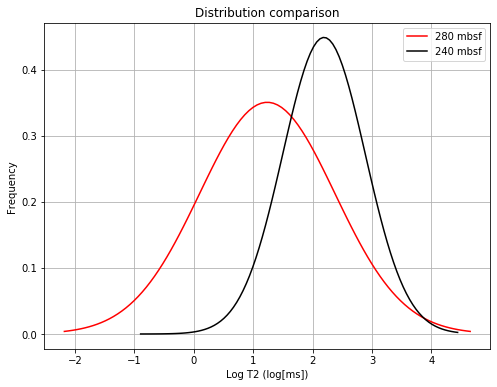

In [4]:
#low MLT2 and high SDT2
MLT2_280=df.loc[(df['Depth']>280) & (df['Depth']<280.2), 'MLT2_all_original']
SDT2_280=df.loc[(df['Depth']>280) & (df['Depth']<280.2), 'SD_all_original']

#high MLT2 and low SDT2
MLT2_240=df.loc[(df['Depth']>240) & (df['Depth']<240.2), 'MLT2_all_original']
SDT2_240=df.loc[(df['Depth']>240) & (df['Depth']<240.2), 'SD_all_original']

#Plotting distributions
x = np.linspace(MLT2_280 - 3*SDT2_280, MLT2_280 + 3*SDT2_280, 100)
plt.plot(x, stats.norm.pdf(x, MLT2_280, SDT2_280),'r',label='280 mbsf')
x1 = np.linspace(MLT2_240 - 3*SDT2_240, MLT2_240 + 3*SDT2_240, 100)
plt.plot(x1, stats.norm.pdf(x, MLT2_240, SDT2_240),'k',label='240 mbsf')
plt.title('Distribution comparison')
plt.xlabel('Log T2 (log[ms])')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.gcf().set_size_inches(8, 6)

In the above figure, at 240 mbsf, a larger mean (MLT2) and smaller standard deviation (SDT2) of the T2 distribution corresponds to a larger and well-sorted pore size.
At 280 mbsf, a smaller mean (MLT2) and larger standard deviation (SDT2) of the T2 distribution corresponds to a smaller and poorly-sorted pore size.
***

In [5]:
#Defining the minimum and maximum of variables for plotting figures

pormin = df['Porosity'].min(); pormax = df['Porosity'].max(); porname = 'Porosity (v/v)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
grmin = df['GR'].min(); grmax = df['GR'].max(); grname = 'Gamma Ray (GAPI)'; grtitle = 'Gamma Ray Log' 
calmin = df['Caliper'].min(); calmax = df['Caliper'].max(); calname = 'Caliper (cm)'; caltitle = 'Caliper Log' 
resmin = df['Ring resistivity'].min(); resmax = df['Ring resistivity'].max(); resname = 'Ring resistivity (ohm-m)'; restitle = 'Ring resistivity Log' 
mlt2min = df['MLT2_all_original'].min(); mlt2max = df['MLT2_all_original'].max(); mlt2name = 'Mean Log of T2 (log[ms])'; mlt2title = 'Mean Log of T2 (NMR)'
sdt2min = df['SD_all_original'].min(); sdt2max = df['SD_all_original'].max(); sdt2name = 'Standard Deviation of T2 (log[ms])'; sdt2title = 'Standard Deviation of T2 (NMR)' 
depthmin = df['Depth'].min(); depthmax = df['Depth'].max(); depthname = 'Depth (mbsf)'; depthtitle = 'Depth in meters below sea-floor (mbsf)' 

All the well-logs are plotted with depth to see the spatial variation

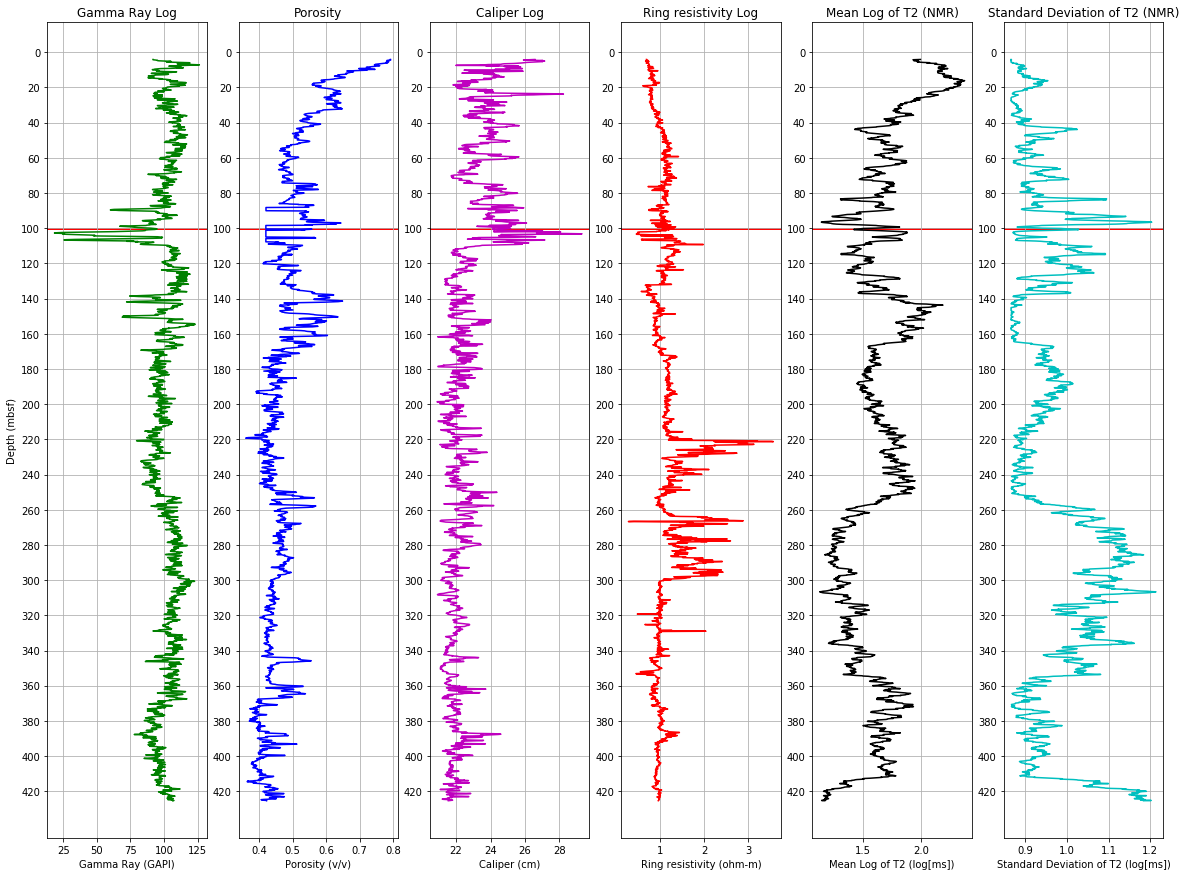

In [6]:
# Plot logs vs depth

plt.subplot(161)
plt.plot(df['GR'].values, df['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,100,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.subplot(162)
plt.plot(df['Porosity'].values, df['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,100,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.subplot(163)
plt.plot(df['Caliper'].values, df['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,100,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.subplot(164)
plt.plot(df['Ring resistivity'].values, df['Depth'].values,'r')
#plt.yscale('linear')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,100,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.subplot(165)
plt.plot(df['MLT2_all_original'].values, df['Depth'].values,'k')
#plt.yscale('linear')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,100,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.subplot(166)
plt.plot(df['SD_all_original'].values, df['Depth'].values,'c')
#plt.yscale('linear')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,100,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.gcf().set_size_inches(20, 15)



From the abnormally large caliper at depths <100 mbsf we can infer that data is not reliable and hence is removed from further analysis.

In [7]:
#Remove all values < 100 mbsf as poor quality data

df_new = df[df['Depth'] > 100]
#Summary statistics of updated data
df_new.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth,2135.0,262.761600,93.949378,100.150800,181.456200,262.761600,344.067000,425.372400
GR,2135.0,100.310577,10.891904,18.468972,94.870892,101.053837,107.310404,123.092765
Porosity,2135.0,0.453623,0.045977,0.359964,0.423329,0.442959,0.474344,0.649344
Caliper,2135.0,22.166484,0.835291,20.896072,21.674963,22.008592,22.426803,29.315156
Ring resistivity,2135.0,1.138586,0.353314,0.269000,0.942100,1.035000,1.208050,3.579700
MLT2_all_original,2135.0,1.572856,0.209225,1.126192,1.401500,1.580279,1.729641,2.191352
SD_all_original,2135.0,0.974016,0.086294,0.865477,0.900136,0.952077,1.039360,1.213652


The summary statistics show that all the variables have values in the expected range and don't require truncation.
***
Updating the minimum and maximum of variables for plotting figures.

In [8]:
pormin = df_new['Porosity'].min(); pormax = df_new['Porosity'].max(); porname = 'Porosity (v/v)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
grmin = df_new['GR'].min(); grmax = df_new['GR'].max(); grname = 'Gamma Ray (GAPI)'; grtitle = 'Gamma Ray Log' 
calmin = df_new['Caliper'].min(); calmax = df_new['Caliper'].max(); calname = 'Caliper (cm)'; caltitle = 'Caliper Log' 
resmin = df_new['Ring resistivity'].min(); resmax = df_new['Ring resistivity'].max(); resname = 'Ring resistivity (ohm-m)'; restitle = 'Ring resistivity Log' 
mlt2min = df_new['MLT2_all_original'].min(); mlt2max = df_new['MLT2_all_original'].max(); mlt2name = 'Mean Log of T2'; mlt2title = 'Mean Log of T2 (NMR)' 
sdt2min = df_new['SD_all_original'].min(); sdt2max = df_new['SD_all_original'].max(); sdt2name = 'Standard Deviation of T2'; sdt2title = 'Standard Deviation of T2 (NMR)' 
depthmin = df_new['Depth'].min(); depthmax = df_new['Depth'].max(); depthname = 'Depth (mbsf)'; depthtitle = 'Depth in meters below sea-floor (mbsf)' 


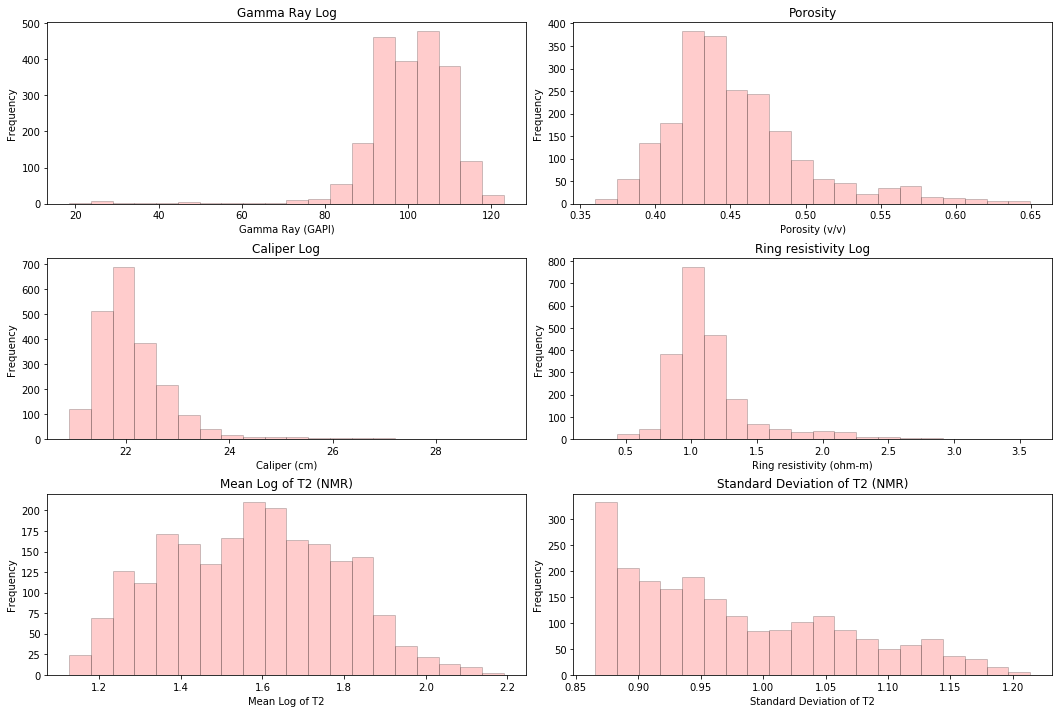

In [9]:
#Plotting univariate distributions

plt.subplot(321)
GSLIB.hist_st(df_new['GR'].values, grmin, grmax, log=False, cumul = False,bins=20, weights = None, xlabel=grname, title=grtitle)

plt.subplot(322)
GSLIB.hist_st(df_new['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel=porname,title=portitle)

plt.subplot(323)
GSLIB.hist_st(df_new['Caliper'].values,calmin,calmax,log=False,cumul = False,bins=20,weights = None,xlabel=calname,title=caltitle)

plt.subplot(324)
GSLIB.hist_st(df_new['Ring resistivity'].values,resmin,resmax,log=False,cumul = False,bins=20,weights = None, xlabel=resname, title=restitle)

plt.subplot(325)
GSLIB.hist_st(df_new['MLT2_all_original'].values,mlt2min,mlt2max,log=False,cumul = False,bins=20,weights = None, xlabel=mlt2name,title=mlt2title)

plt.subplot(326)
GSLIB.hist_st(df_new['SD_all_original'].values,sdt2min,sdt2max,log=False,cumul = False,bins=20,weights = None, xlabel=sdt2name,title=sdt2title)


plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.gcf().set_size_inches(18, 12)
#plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

The univariate distributions show that there are no obvious missing data, gaps, significant truncations, spikes or outliers.

<Figure size 1440x1440 with 0 Axes>

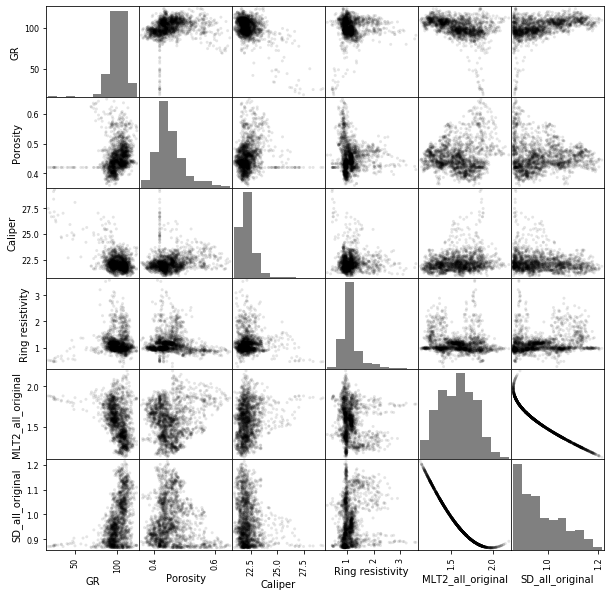

In [10]:
#Plotting bivariate distributions

plt.figure(figsize=(20,20)) 
pd_plot.scatter_matrix(df_new.drop('Depth', axis = 1), alpha = 0.1,              # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.gcf().set_size_inches(10, 10)
plt.show()

The bivariate distributions shows complex relationships between the different variables. The plot between MLT2 and SDT2 can be ignored due to known existing correlation.
***
For initial testing, a linear regression is conducted for MLT2 and SDT2 with other variables

In [11]:
#Linear regression with statsmodels for MLT2

X1 = df_new[['GR','Porosity','Caliper','Ring resistivity']] # here we have 4 input variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y1 = df_new['MLT2_all_original'] # output variable (what we are trying to predict)
X1 = sm.add_constant(X1) # adding a constant
 
model1 = sm.OLS(Y1, X1).fit()
predictions1 = model1.predict(X1)
print_model1 = model1.summary()
print(print_model1)

                            OLS Regression Results                            
Dep. Variable:      MLT2_all_original   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     162.6
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          1.41e-121
Time:                        00:05:21   Log-Likelihood:                 595.40
No. Observations:                2135   AIC:                            -1181.
Df Residuals:                    2130   BIC:                            -1152.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.7643      0.148  

The MLT2 regression results with low R2 and low coefficients shows that standardization and further processing is required

In [12]:
#Linear regression with statsmodels for SDT2

X2 = df_new[['GR', 'Porosity', 'Caliper', 'Ring resistivity']] # here we have 4 input variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y2 = df_new['SD_all_original'] # output variable (what we are trying to predict)
X2 = sm.add_constant(X2) # adding a constant
 
model2 = sm.OLS(Y2, X2).fit()
predictions2 = model2.predict(X2)
print_model2 = model2.summary()
print(print_model2)

                            OLS Regression Results                            
Dep. Variable:        SD_all_original   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     166.8
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          2.40e-124
Time:                        00:05:21   Log-Likelihood:                 2492.7
No. Observations:                2135   AIC:                            -4975.
Df Residuals:                    2130   BIC:                            -4947.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4439      0.061  

The SDT2 regression results with low R2 and low coefficients shows that standardization and further processing is required

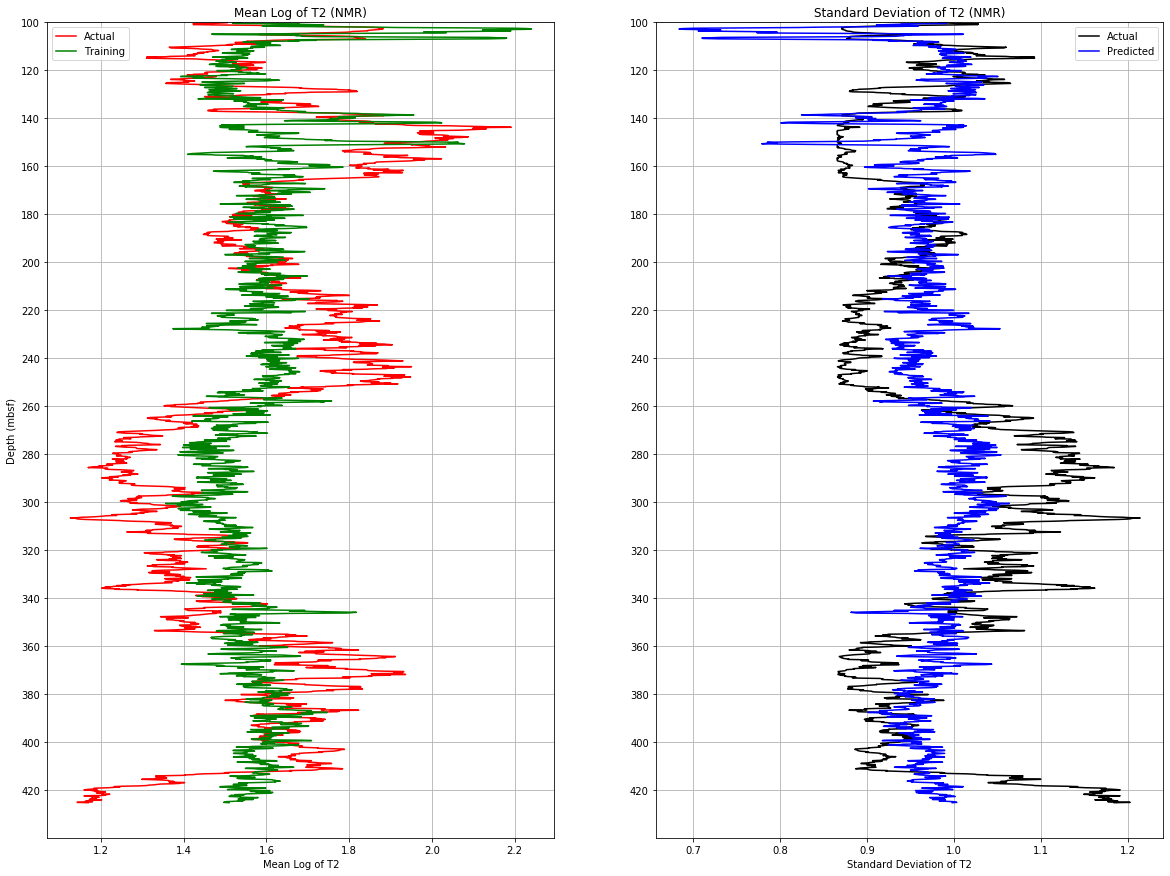

In [13]:
#Comparison between original and predicted MLT2 and SDT2

plt.subplot(121)
plt.plot(df_new['MLT2_all_original'].values, df_new['Depth'].values,'r',label='Actual')
plt.plot(predictions1, df_new['Depth'].values,'g',label='Training')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df_new['Depth'].values), 20.0))
plt.grid(True)
plt.gca().set_ylim([100,440])
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(122)
plt.plot(df_new['SD_all_original'].values, df_new['Depth'].values,'k',label='Actual')
plt.plot(predictions2, df_new['Depth'].values,'b',label='Predicted')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df_new['Depth'].values), 20.0))
plt.grid(True)
plt.gca().set_ylim([100,440])
plt.gca().invert_yaxis()
plt.legend()

plt.gcf().set_size_inches(20, 15)

The log comparisons show that the regression cannot capture the behavior well, possibly due to lack of standardization, resolution issues and non-linearity.
***
The variables are standardized for further analysis

In [14]:
#Standardization

scaler = StandardScaler()                     # instantiate the scaler 
dfS = df_new.copy()
depth=df_new['Depth']
MLT2=df_new['MLT2_all_original']
SDT2=df_new['SD_all_original']
scaler.fit(dfS.drop('Depth',axis=1))
dfS1 = scaler.transform(dfS.drop('Depth', axis = 1)) # standardize all the values extracted from the DataFrame except Depth
transformer_MLT2 = scaler.fit(MLT2.values.reshape(-1, 1))
dfS = pd.DataFrame(dfS1, index = dfS.index, columns = dfS.drop('Depth', axis = 1).columns)
dfS.insert(0, 'Depth', depth)
scaler2 = StandardScaler()                     # instantiate the scaler 
transformer_SDT2 = scaler2.fit(SDT2.values.reshape(-1, 1))
dfS.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
count,2135.000000,2.135000e+03,2.135000e+03,2.135000e+03,2.135000e+03,2.135000e+03,2.135000e+03
mean,262.761600,4.717018e-16,6.153288e-16,2.242807e-15,1.577193e-16,-6.848542e-16,1.331020e-15
std,93.949378,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00
min,100.150800,-7.515745e+00,-2.037573e+00,-1.521278e+00,-2.461804e+00,-2.135347e+00,-1.258069e+00
25%,181.456200,-4.995416e-01,-6.590529e-01,-5.885804e-01,-5.562540e-01,-8.191936e-01,-8.563396e-01
50%,262.761600,6.825567e-02,-2.319974e-01,-1.890702e-01,-2.932535e-01,3.548989e-02,-2.542971e-01
75%,344.067000,6.428138e-01,4.507723e-01,3.117242e-01,1.966521e-01,7.495356e-01,7.573968e-01
max,425.372400,2.092153e+00,4.257927e+00,8.560309e+00,6.910807e+00,2.956823e+00,2.777612e+00


The values after standardization have a mean of 0 and std of 1 (except depth which is the reference)


In [15]:
#Saving variables for inverse scaling
mlt2mean = df_new['MLT2_all_original'].mean();
mlt2sd = df_new['MLT2_all_original'].std();
sdt2mean = df_new['SD_all_original'].mean();
sdt2sd = df_new['SD_all_original'].std();

<Figure size 1440x1440 with 0 Axes>

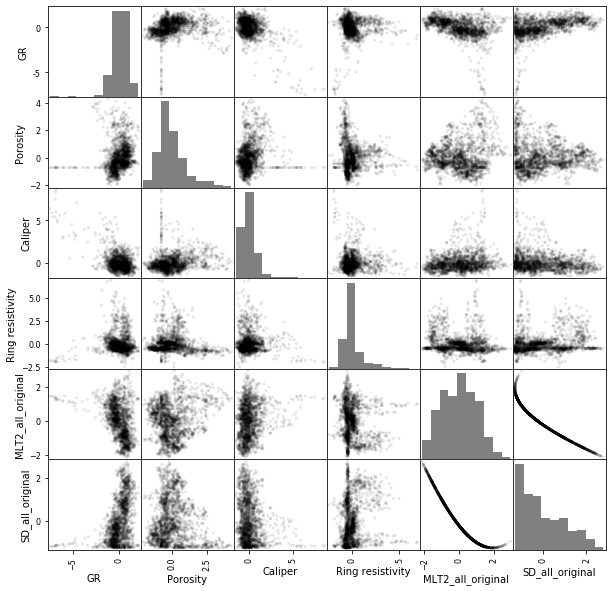

In [16]:
#Plotting bivariate distributions

plt.figure(figsize=(20,20)) 
pd_plot.scatter_matrix(dfS.drop('Depth', axis = 1), alpha = 0.1,              # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.gcf().set_size_inches(10, 10)
plt.show()


The bivariate distributions still shows complex relationships between the different variables. The plot between MLT2 and SDT2 can be ignored due to known existing correlation.
***

### Feature ranking
***

Pairwise covariance provides a measure of the strength of the linear relationship between each predictor feature and the response feature but varies in magnitude according to units. Not seen in this case due to standardization.

In [17]:
#Find covariance
covariance1 = dfS.iloc[:,1:7].cov().iloc[4,:4]
covariance2 = dfS.iloc[:,1:7].cov().iloc[5,:4]

#print(covariance1)
#print(covariance2)

Pairwise correlation coefficient provides a measure of the strength of the linear relationship between each predictor feature and the response feature.

In [18]:
#Find pairwise correlation coefficient
correlation1 = dfS.iloc[:,1:7].corr().iloc[4,:4]
correlation2 = dfS.iloc[:,1:7].corr().iloc[5,:4]

#print(correlation1)
#print(correlation2)

The rank correlation coefficient applies the rank transform to the data prior to calculating the correlation coefficent and thus relaxing the linear assumption

In [19]:
#Find Pairwise Spearman rank correlation coefficient
rank_correlation, rank_correlation_pval = stats.spearmanr(dfS.iloc[:,1:7]) # calculate the range correlation coefficient

rank_correlation1 = rank_correlation[:,4][:4]
rank_correlation_pval1 = rank_correlation_pval[:,4][:4]

#print('MLT2')
#print('rank_correlation')
#print(rank_correlation1)
#print('rank_correlation_pval')
#print(rank_correlation_pval1)

rank_correlation2 = rank_correlation[:,5][:4]
rank_correlation_pval2 = rank_correlation_pval[:,5][:5]
#print('SDT2')
#print('rank_correlation')
#print(rank_correlation2)
#print('rank_correlation_pval')
#print(rank_correlation_pval2)

In [20]:
#Partial Correlation in Python (clone of Matlab's partialcorr)

#This uses the linear regression approach to compute the partial correlation 
#(might be slow for a huge number of variables). The algorithm is detailed here:

# http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

#Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
#the algorithm can be summarized as
#    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
#    2) calculate the residuals in Step #1
#    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
#    4) calculate the residuals in Step #3
#    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
#    The result is the partial correlation between X and Y while controlling for the effect of Z

#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

Partial Correlation Coefficient is a linear correlation coefficient that controls for the effects all the remaining variables, $\rho_{XY.Z}$ and $\rho_{YX.Z}$ is the partial correlation between $X$ and $Y$, $Y$ and $X$, after controlling for $Z$.

In [21]:
#Find partial correlation

partial_correlation = partial_corr(dfS.iloc[:,1:7]) # calculate the partial correlation coefficients
#print(partial_correlation)
partial_correlation1 = partial_correlation[:,4][:4] # extract a single row and remove with itself
#print(partial_correlation1)

partial_correlation2 = partial_correlation[:,5][:4] # extract a single row and remove with itself
#print(partial_correlation2)

Semipartial Correlation Coefficient is a linear correlation coefficient that controls for the effects all the remaining features, $Z$ on $X$, and then calculates the correlation between the residual $X^*-X$ and $Y$. It filters out the influence of all other predictor features on the raw response variable.

In [22]:
#Find semi-partial correlation

semipartial_correlation = semipartial_corr(dfS.iloc[:,1:7]) # calculate the partial correlation coefficients
#print(partial_correlation)
semipartial_correlation1 = semipartial_correlation[:,4][:4] # extract a single row and remove with itself
#print(semipartial_correlation1)

semipartial_correlation2 = semipartial_correlation[:,5][:4] # extract a single row and remove with itself
#print(semipartial_correlation2)

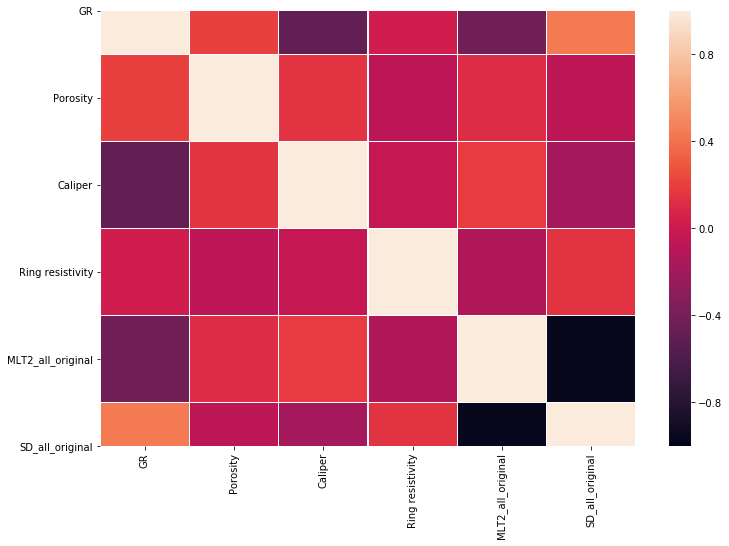

In [23]:
# Color coded correlation matrix

plt.subplot(111)                          # plot a color coded correlation matrix
sns.heatmap(dfS.iloc[:,1:7].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.gcf().set_size_inches(12, 8)
plt.show()

The color coded correlation matrix shows that GR and Resistivity have high correlations with MLT2 (ignoring SDT2). Also, GR and Caliper have high correlations with SDT2 (ignoring MLT2)

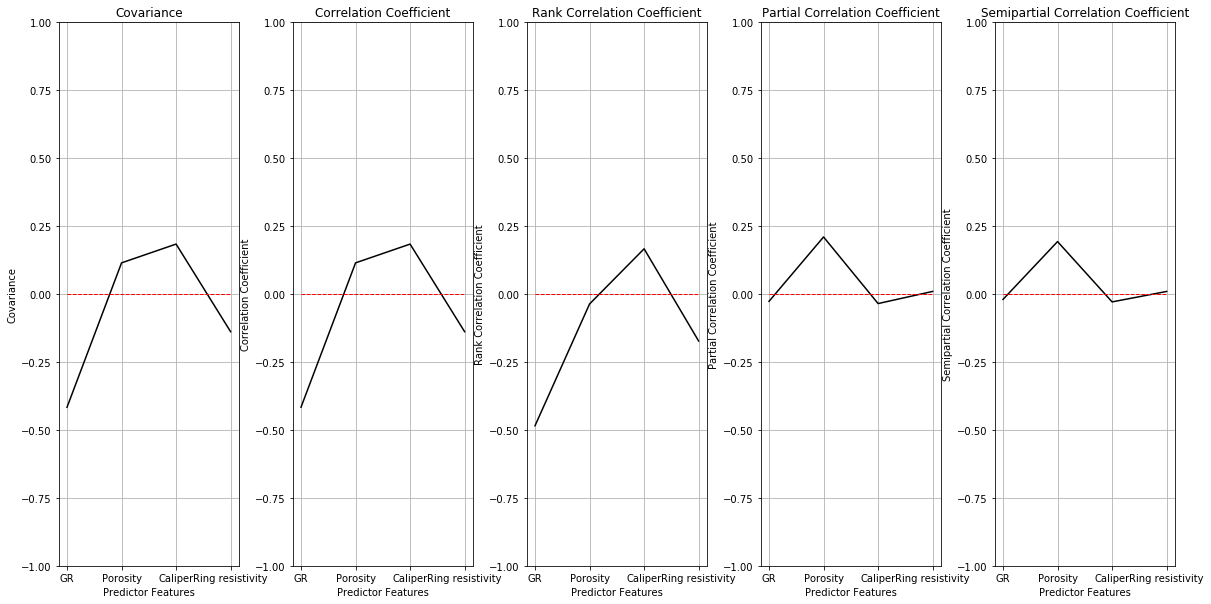

In [24]:
#Comparing different methods of feature ranking for MLT2

features = dfS.columns.values[1:][:4]
plt.subplot(151)
plt.plot(features,covariance1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,rank_correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,partial_correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,semipartial_correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.gcf().set_size_inches(20, 10)
plt.show()

It is seen from the plots for MLT2 that GR is the most important variable for relationships, then Resistivity, Caliper and Porosity

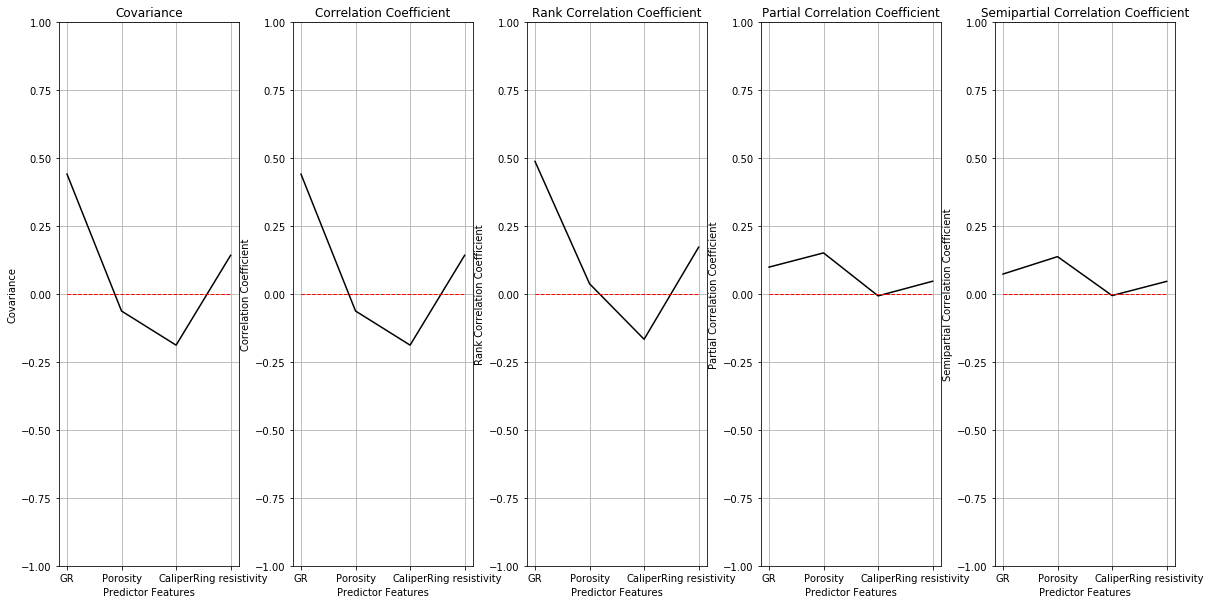

In [25]:
#Comparing different methods of feature ranking for SDT2

features = dfS.columns.values[1:][:4]
plt.subplot(151)
plt.plot(features,covariance2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,rank_correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,partial_correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,semipartial_correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.gcf().set_size_inches(20, 10)
plt.show()

It is also seen from the plots for SDT2 that GR is the most important variable for relationships, then Resistivity, Caliper and Porosity
***
Principal Component Analysis one of a variety of methods for dimensional reduction. It is attempted to see if diensionality reduction can capture the variance from the predictors in fewer features. 


[0.37536678 0.28375148 0.24072827 0.10015348]


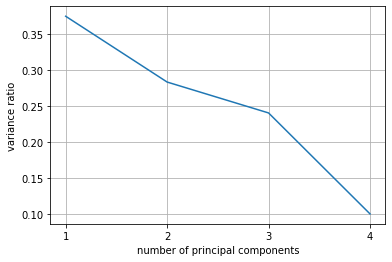

In [26]:
pca1 = PCA(n_components=4)
dfS1 = dfS.iloc[:,[1,2,3,4]] # all predictors

pca1.fit(dfS1)
#print(pca1.components_)
print(pca1.explained_variance_ratio_)
plt.plot(range(1,5), pca1.explained_variance_ratio_)
plt.xlabel("number of principal components")
plt.ylabel("variance ratio")
plt.xticks(np.arange(1,5,1))
plt.grid(True)

It is seen that 37.5% variance is captured in first principal component, 28.3% in second principal component, 24.0% in the third and 10% in the fourth. Since, there is no significant advantage by reducing the dimensions from four to three or two, hence, same dimensionality is retained going forward.
***
### Data Processing 

Since there is noise (high resolution) in the data which cannot be captured during the regression analysis, the logs are smoothened considering a window size of ~3 m

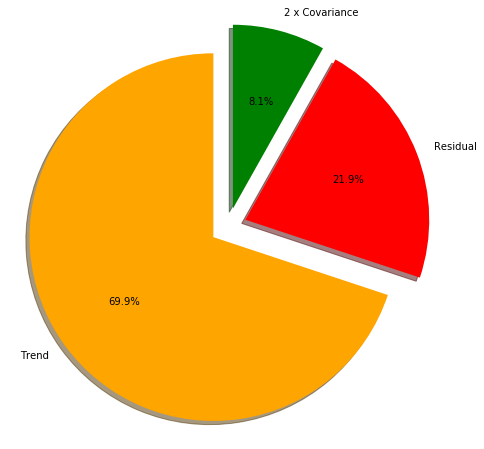

In [27]:
window_size = 21                        # assume window size in depth 3 m (Reduced vertical resolution to get better prediction)
                                        #Window size affecting R2.
#Determing rolling statistics
dfR = dfS.rolling(window = window_size, center = True).mean()

dfW = pd.DataFrame()
dfW['rolling_mean'] = dfR['GR'].values
dfW['residual'] = dfS['GR'].values - dfR['GR'].values
variance = np.var(dfS['GR'])
variance_trend = np.var(dfW['rolling_mean'])
variance_residual = np.var(dfW['residual'])
prop_trend = variance_trend/variance
prop_resid = variance_residual/variance
prop_cov = 1 - prop_trend - prop_resid
variance_prop = [prop_trend, prop_resid, prop_cov]
labels = 'Trend', 'Residual', '2 x Covariance'
colors = 'orange', 'red', 'green'
explode = (0.1, 0.1,0.1)
fig1, ax1 = plt.subplots()
ax1.pie(variance_prop, explode=explode, colors = colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gcf().set_size_inches(8, 8)
plt.show()

It is seen that ~22% of the variance (residual) constitutes noise and removing it can improve the regression model. 

In [28]:
# Remove NaN values introduced during the rolling progress
dfS=dfR
dfS=dfS.dropna()
dfS.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
count,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000
mean,262.761600,0.006649,0.002280,-0.014055,0.003657,0.008706,-0.010634
std,93.069496,0.836284,0.893393,0.799285,0.882508,0.958899,0.956843
min,101.674800,-5.287038,-1.527937,-1.199103,-1.241371,-1.881774,-1.246091
25%,182.218200,-0.441722,-0.560773,-0.472103,-0.554993,-0.797819,-0.817976
50%,262.761600,0.094749,-0.230328,-0.178772,-0.299387,0.095620,-0.299577
75%,343.305000,0.608629,0.491722,0.226495,0.191408,0.722576,0.736263
max,423.848400,1.589706,3.326923,5.096873,4.483692,2.336629,2.354188


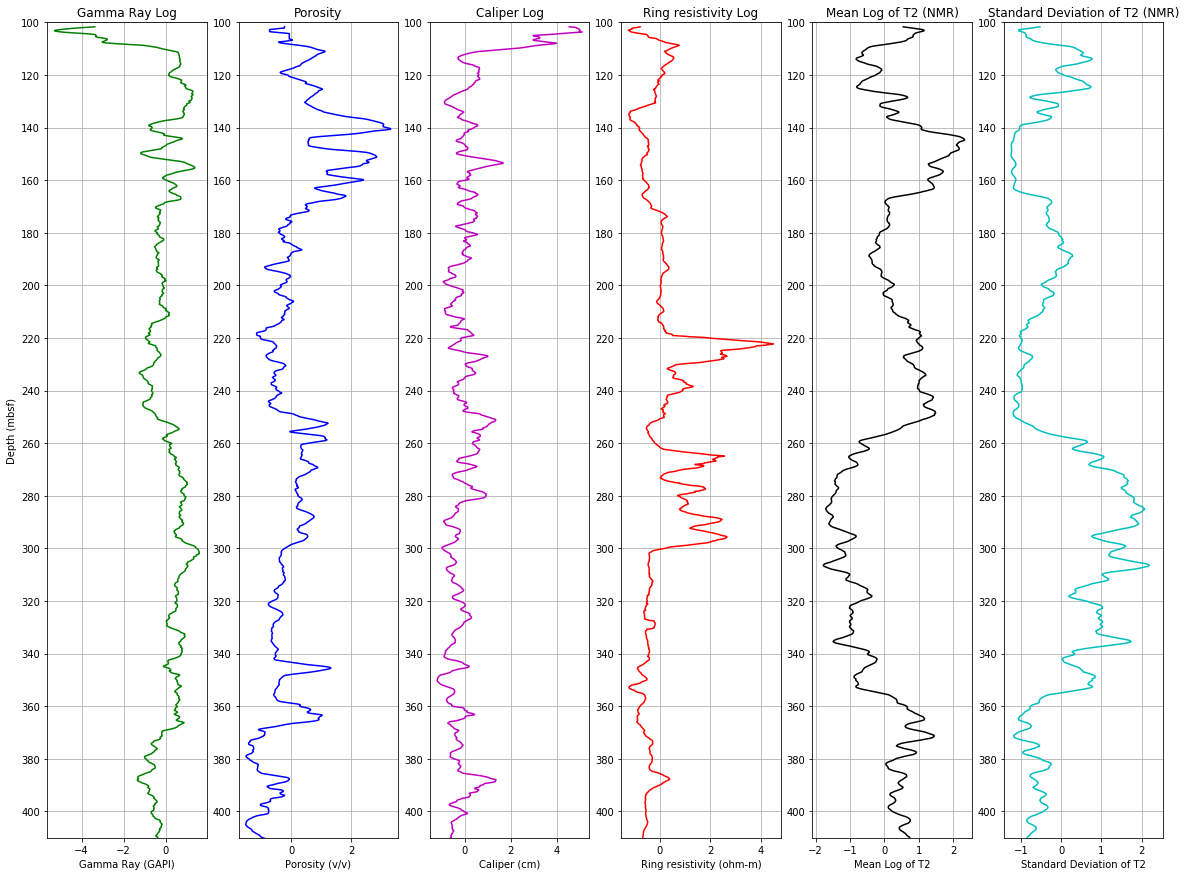

In [29]:
# Plot logs vs depth
plt.subplot(161)
plt.plot(dfR['GR'].values, dfR['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(162)
plt.plot(dfR['Porosity'].values, dfR['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(163)
plt.plot(dfR['Caliper'].values, dfR['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(164)
plt.plot(dfR['Ring resistivity'].values, dfR['Depth'].values,'r')
#plt.yscale('linear')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(165)
plt.plot(dfR['MLT2_all_original'].values, dfR['Depth'].values,'k')
#plt.yscale('linear')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(166)
plt.plot(dfR['SD_all_original'].values, dfR['Depth'].values,'c')
#plt.yscale('linear')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.gcf().set_size_inches(20, 15)

It can be observed that the logs have been smoothened which will improve the regression fit.

In [30]:
#Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(dfS.iloc[:,[0,1,2,3,4]],dfS.iloc[:,[0,5,6]], test_size=0.2)
print('Number of training data = ' + str(len(X_train)) + ' and number of testing data = ' + str(len(X_test)))

Number of training data = 1692 and number of testing data = 423


Before regression analysis, the log data is split into train and test parts in ratio 80:20.

In [31]:
# Sort according to depth for plotting
X_train.sort_values(by=['Depth'], inplace=True)
Y_train.sort_values(by=['Depth'], inplace=True)
X_test.sort_values(by=['Depth'], inplace=True)
Y_test.sort_values(by=['Depth'], inplace=True)
#X_train.head()

### Polynomial Regression

Since non-linear reationships were observed in the variables during the feature ranking and bivariate analysis, hence polynomial regression was selected for creating a model. Moreover, Hermite polynomials were used to reduce the correlation between the basis predictor features and variables upto power 3 were used.

In [32]:
#Creating Hermite Table for MLT2 and SDT2 Training using all variables
orders3 = [0,1,2,3]
hermite_GR = scipy.special.eval_hermitenorm(orders3, X_train['GR'].values.reshape(-1, 1), out=None)
hermite_Porosity = scipy.special.eval_hermitenorm(orders3, X_train['Porosity'].values.reshape(-1, 1), out=None)
hermite_Caliper = scipy.special.eval_hermitenorm(orders3, X_train['Caliper'].values.reshape(-1, 1), out=None)
hermite_Resistivity = scipy.special.eval_hermitenorm(orders3, X_train['Ring resistivity'].values.reshape(-1, 1), out=None)

df_hermite = pd.DataFrame({'GR0': hermite_GR[:,0],'GR1': hermite_GR[:,1],'GR2': hermite_GR[:,2], 'GR3': hermite_GR[:,3], 'Por0': hermite_Porosity[:,0], 'Por1': hermite_Porosity[:,1], 'Por2': hermite_Porosity[:,2], 'Por3': hermite_Porosity[:,3], 'Cal0': hermite_Caliper[:,0], 'Cal1': hermite_Caliper[:,1], 'Cal2': hermite_Caliper[:,2], 'Cal3': hermite_Caliper[:,3], 'Res0': hermite_Resistivity[:,0], 'Res1': hermite_Resistivity[:,1], 'Res2': hermite_Resistivity[:,2], 'Res3': hermite_Resistivity[:,3]}) # make a new DataFrame from the vectors
#df_hermite.head()

In [33]:
#Covariance comparison between variables Training
df_hermite.iloc[:,0:].corr()

,GR0,GR1,GR2,GR3,Por0,Por1,Por2,Por3,Cal0,Cal1,Cal2,Cal3,Res0,Res1,Res2,Res3
GR0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GR1,NaN,1.000000,-0.580005,0.442092,NaN,0.254340,-0.075895,-0.236827,NaN,-0.583783,-0.603352,-0.576658,NaN,0.004118,-0.007530,-0.053963
GR2,NaN,-0.580005,1.000000,-0.942029,NaN,-0.036747,-0.038838,0.012819,NaN,0.680758,0.927818,0.936260,NaN,-0.093816,-0.002746,-0.005714
GR3,NaN,0.442092,-0.942029,1.000000,NaN,0.000732,0.063054,0.042837,NaN,-0.591736,-0.869352,-0.925173,NaN,0.121086,-0.006941,0.007025
Por0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Por1,NaN,0.254340,-0.036747,0.000732,NaN,1.000000,0.594068,0.220938,NaN,0.190207,-0.022208,-0.083607,NaN,-0.085884,-0.005499,-0.042785
Por2,NaN,-0.075895,-0.038838,0.063054,NaN,0.594068,1.000000,0.798749,NaN,0.077351,-0.050006,-0.065974,NaN,-0.260775,-0.033732,0.030488
Por3,NaN,-0.236827,0.012819,0.042837,NaN,0.220938,0.798749,1.000000,NaN,0.014620,-0.004837,-0.000779,NaN,-0.190190,-0.015745,0.060275
Cal0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cal1,NaN,-0.583783,0.680758,-0.591736,NaN,0.190207,0.077351,0.014620,NaN,1.000000,0.765908,0.624445,NaN,-0.012578,-0.042208,-0.075439


The above table shows that there is some correlation between variables at higher powers but it is minimized by using Hermite polynomials

In [34]:
#Creating Hermite Table for MLT2 and SDT2 Testing using all variables

orders3 = [0,1,2,3]
hermite_GR = scipy.special.eval_hermitenorm(orders3, X_test['GR'].values.reshape(-1, 1), out=None)
hermite_Porosity = scipy.special.eval_hermitenorm(orders3, X_test['Porosity'].values.reshape(-1, 1), out=None)
hermite_Caliper = scipy.special.eval_hermitenorm(orders3, X_test['Caliper'].values.reshape(-1, 1), out=None)
hermite_Resistivity = scipy.special.eval_hermitenorm(orders3, X_test['Ring resistivity'].values.reshape(-1, 1), out=None)

df_hermite_test = pd.DataFrame({'GR0': hermite_GR[:,0],'GR1': hermite_GR[:,1],'GR2': hermite_GR[:,2], 'GR3': hermite_GR[:,3], 'Por0': hermite_Porosity[:,0], 'Por1': hermite_Porosity[:,1], 'Por2': hermite_Porosity[:,2], 'Por3': hermite_Porosity[:,3], 'Cal0': hermite_Caliper[:,0], 'Cal1': hermite_Caliper[:,1], 'Cal2': hermite_Caliper[:,2], 'Cal3': hermite_Caliper[:,3], 'Res0': hermite_Resistivity[:,0], 'Res1': hermite_Resistivity[:,1], 'Res2': hermite_Resistivity[:,2], 'Res3': hermite_Resistivity[:,3]}) # make a new DataFrame from the vectors
#df_hermite_test.head()

In [35]:
#Covariance comparison between variables Testing
df_hermite_test.iloc[:,0:].corr()

,GR0,GR1,GR2,GR3,Por0,Por1,Por2,Por3,Cal0,Cal1,Cal2,Cal3,Res0,Res1,Res2,Res3
GR0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GR1,NaN,1.000000,-0.645667,0.521451,NaN,0.215436,-0.106293,-0.251708,NaN,-0.664481,-0.675040,-0.642743,NaN,-0.011898,-0.002378,-0.030615
GR2,NaN,-0.645667,1.000000,-0.949022,NaN,-0.075266,-0.058785,0.024794,NaN,0.710613,0.927059,0.944014,NaN,-0.093819,0.007550,-0.003549
GR3,NaN,0.521451,-0.949022,1.000000,NaN,0.032565,0.072653,0.032529,NaN,-0.625026,-0.859965,-0.922910,NaN,0.129611,-0.021520,-0.001705
Por0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Por1,NaN,0.215436,-0.075266,0.032565,NaN,1.000000,0.615943,0.250250,NaN,0.177433,-0.056429,-0.112908,NaN,-0.120249,0.021102,-0.017553
Por2,NaN,-0.106293,-0.058785,0.072653,NaN,0.615943,1.000000,0.798708,NaN,0.085376,-0.062286,-0.082959,NaN,-0.291026,-0.019792,0.051452
Por3,NaN,-0.251708,0.024794,0.032529,NaN,0.250250,0.798708,1.000000,NaN,0.035437,0.009055,0.005427,NaN,-0.206930,-0.019847,0.059625
Cal0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cal1,NaN,-0.664481,0.710613,-0.625026,NaN,0.177433,0.085376,0.035437,NaN,1.000000,0.811002,0.691686,NaN,-0.024035,-0.039723,-0.068685


The above table also shows that there is some correlation between variables at higher powers but it is minimized by using Hermite polynomials
***
The regression model was trained to predict MLT2 and SDT2 using the Hermite polynomials

In [36]:
#Training MLT2
lin_herm = LinearRegression() 
lin_herm.fit(df_hermite.iloc[:,0:], Y_train['MLT2_all_original']) 
MLT2_herm_pred=lin_herm.predict(df_hermite)
#MLT2_poly_pred2=transformer_MLT2.inverse_transform(MLT2_herm_pred.reshape(-1, 1))
#MLT2_S=transformer_MLT2.inverse_transform(Y_train['MLT2_all_original'].values.reshape(-1, 1))
MLT2_poly_pred= mlt2mean+(MLT2_herm_pred*mlt2sd) #Remove standardization
MLT2_S= mlt2mean+(Y_train['MLT2_all_original'].values*mlt2sd) #Remove standardization
print('Coefficient of regression (R2) for MLT2 Training')
r2_score(MLT2_S, MLT2_poly_pred)

Coefficient of regression (R2) for MLT2 Training


0.5054903501287946

In [37]:
#Training SDT2
lin_herm2 = LinearRegression() 
lin_herm2.fit(df_hermite.iloc[:,0:], Y_train['SD_all_original']) 
SDT2_herm_pred=lin_herm2.predict(df_hermite)

SDT2_poly_pred= sdt2mean+(SDT2_herm_pred*sdt2sd) #Remove standardization
SDT2_S= sdt2mean+(Y_train['SD_all_original'].values*sdt2sd) #Remove standardization
print('Coefficient of regression (R2) for SDT2 Training')
r2_score(SDT2_S, SDT2_poly_pred)

Coefficient of regression (R2) for SDT2 Training


0.5121272361921252

In [38]:
#Testing MLT2
MLT2_herm_pred_test=lin_herm.predict(df_hermite_test)
MLT2_poly_pred_test= mlt2mean+(MLT2_herm_pred_test*mlt2sd) #Remove standardization
MLT2_S_test= mlt2mean+(Y_test['MLT2_all_original'].values*mlt2sd) #Remove standardization
print('Coefficient of regression (R2) for MLT2 Testing')
r2_score(MLT2_S_test, MLT2_poly_pred_test)

Coefficient of regression (R2) for MLT2 Testing


0.49071080968753134

In [39]:
#Testing SDT2
SDT2_herm_pred_test=lin_herm2.predict(df_hermite_test)
SDT2_poly_pred_test= sdt2mean+(SDT2_herm_pred_test*sdt2sd) #Remove standardization
SDT2_S_test= sdt2mean+(Y_test['SD_all_original'].values*sdt2sd) #Remove standardization
print('Coefficient of regression (R2) for SDT2 Testing')
r2_score(SDT2_S_test, SDT2_poly_pred_test)

Coefficient of regression (R2) for SDT2 Testing


0.509514101773286

It can be observed that the R2 values for training and testing for both MLT2 and SDT2 are comparable which shows that model variance and bias are balanced without overfit or udnerfit. This is better seen in the prediction comparison with actual data.

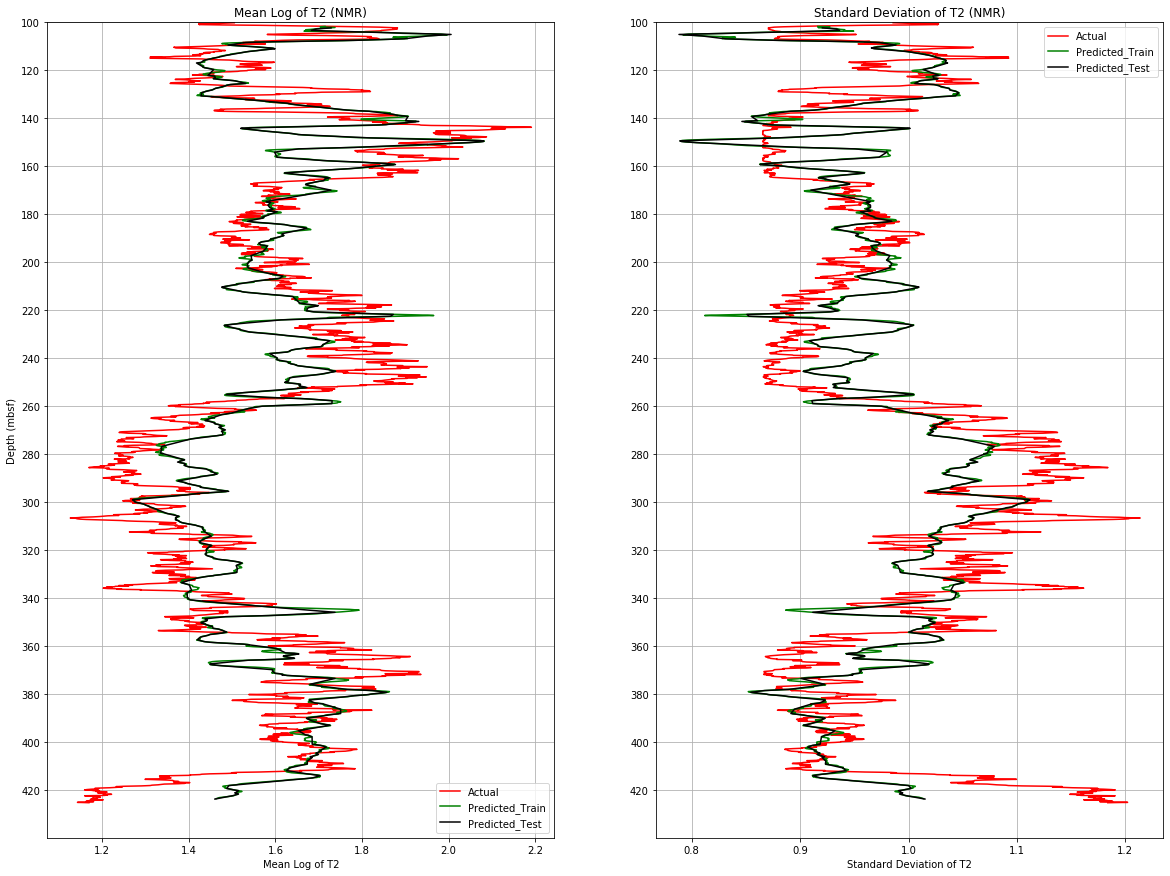

In [40]:
#Actual data comparison with train and test predictions

plt.subplot(121)
plt.plot(df_new['MLT2_all_original'].values, df_new['Depth'].values,'r',label='Actual')
plt.plot(MLT2_poly_pred, Y_train['Depth'].values,'g',label='Predicted_Train')
plt.plot(MLT2_poly_pred_test, Y_test['Depth'].values,'k',label='Predicted_Test')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df_new['Depth'].values), 20.0))
plt.grid(True)
plt.gca().set_ylim([100,440])
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(122)
plt.plot(df_new['SD_all_original'].values, df_new['Depth'].values,'r',label='Actual')
plt.plot(SDT2_poly_pred, Y_train['Depth'].values,'g',label='Predicted_Train')
plt.plot(SDT2_poly_pred_test, Y_test['Depth'].values,'k',label='Predicted_Test')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df_new['Depth'].values), 20.0))
plt.grid(True)
plt.gca().set_ylim([100,440])
plt.gca().invert_yaxis()
plt.legend()

plt.gcf().set_size_inches(20, 15)

It can be observed that the training and testing results overlap, and do a good job of capturing the actual log behavior.
***

### Prediction of Walker Ridge data


In [41]:
# Load WR data, smoothen it and remove data dissimilar to trained model.

df_WR = pd.read_csv(r'C:\Users\Abhishek\Desktop\python regression\WR313H_logs.csv')
df_WR = df_WR[df_WR['Depth'] < 800]  #remove all values > 800 mbsf as data is not similar to training data
df_WR = df_WR.rolling(window = 30, center = True).mean()
df_WR=df_WR.dropna()

In [42]:
df_WR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth,5044.0,413.383097,222.067509,2.362200,221.322900,413.461200,605.599500,797.737800
GR,5044.0,100.885515,7.403410,77.408048,94.409234,101.353413,106.912340,115.880903
Porosity,5044.0,0.370058,0.066106,0.276255,0.325644,0.350647,0.390833,0.826157
Caliper,5044.0,21.766212,0.333307,21.185632,21.567625,21.706798,21.850858,23.807843
Ring resistivity,5044.0,1.983267,0.689842,0.567267,1.588106,1.889100,2.219243,6.531423


The summary statistics show that the data is within expected range without truncations.

In [43]:
#Defining the minimum and maximum of variables for plotting figures

pormin = df_WR['Porosity'].min(); pormax = df_WR['Porosity'].max(); porname = 'Porosity (v/v)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
grmin = df_WR['GR'].min(); grmax = df_WR['GR'].max(); grname = 'Gamma Ray (GAPI)'; grtitle = 'Gamma Ray Log' 
calmin = df_WR['Caliper'].min(); calmax = df_WR['Caliper'].max(); calname = 'Caliper (cm)'; caltitle = 'Caliper Log' 
resmin = df_WR['Ring resistivity'].min(); resmax = df_WR['Ring resistivity'].max(); resname = 'Ring resistivity (ohm-m)'; restitle = 'Ring resistivity Log' 
depthmin = df_WR['Depth'].min(); depthmax = df_WR['Depth'].max(); depthname = 'Depth (mbsf)'; depthtitle = 'Depth in meters below sea-floor (mbsf)' 


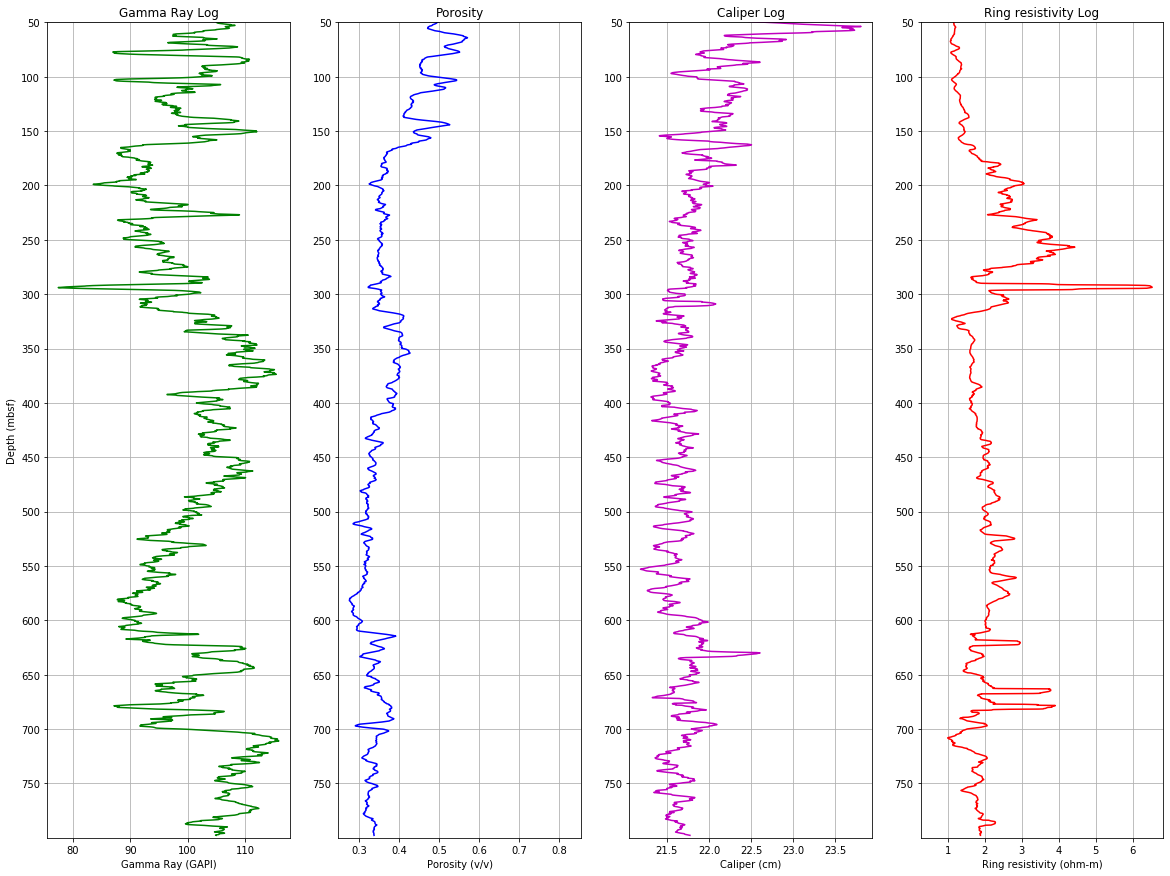

In [44]:
# Plot logs vs depth

plt.subplot(141)
plt.plot(df_WR['GR'].values, df_WR['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(142)
plt.plot(df_WR['Porosity'].values, df_WR['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(143)
plt.plot(df_WR['Caliper'].values, df_WR['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(144)
plt.plot(df_WR['Ring resistivity'].values, df_WR['Depth'].values,'r')
#plt.xscale('log')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()


plt.gcf().set_size_inches(20, 15)

It can be observed that the logs have been smoothened which will improve the regression fit.

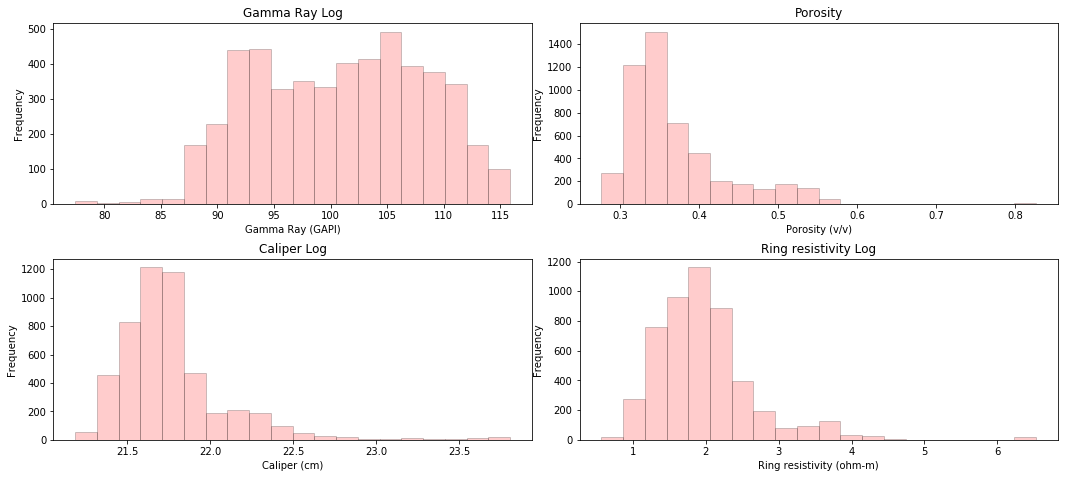

In [45]:
#Plotting univariate distributions

plt.subplot(321)
GSLIB.hist_st(df_WR['GR'].values, grmin, grmax, log=False, cumul = False,bins=20, weights = None, xlabel=grname, title=grtitle)

plt.subplot(322)
GSLIB.hist_st(df_WR['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel=porname,title=portitle)

plt.subplot(323)
GSLIB.hist_st(df_WR['Caliper'].values,calmin,calmax,log=False,cumul = False,bins=20,weights = None,xlabel=calname,title=caltitle)

plt.subplot(324)
GSLIB.hist_st(df_WR['Ring resistivity'].values,resmin,resmax,log=False,cumul = False,bins=20,weights = None, xlabel=resname, title=restitle)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.gcf().set_size_inches(18, 12)
plt.show()

The univariate distributions show that there are no obvious missing data, gaps, significant truncations, spikes or outliers.

In [46]:
#Standardization

dfS_WR = df_WR.copy()
depth=df_WR['Depth']
#scaler.fit(dfS_WR.drop('Depth',axis=1))
dfS1_WR = scaler.fit_transform(dfS_WR.drop('Depth', axis = 1)) # standardize all the values extracted from the DataFrame except Depth

dfS_WR = pd.DataFrame(dfS1_WR, index = dfS_WR.index, columns = dfS_WR.drop('Depth', axis = 1).columns)
dfS_WR.insert(0, 'Depth', depth)
dfS_WR.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity
count,5044.000000,5.044000e+03,5.044000e+03,5.044000e+03,5.044000e+03
mean,413.383097,-1.514341e-17,-6.456748e-16,7.802355e-15,2.486886e-16
std,222.067509,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00
min,2.362200,-3.171484e+00,-1.419118e+00,-1.742047e+00,-2.052847e+00
25%,221.322900,-8.748568e-01,-6.719275e-01,-5.958659e-01,-5.728848e-01
50%,413.461200,6.320660e-02,-2.936648e-01,-1.782732e-01,-1.365183e-01
75%,605.599500,8.141413e-01,3.143001e-01,2.539843e-01,3.421072e-01
max,797.737800,2.025671e+00,6.900203e+00,6.125980e+00,6.593694e+00


The values after standardization have a mean of 0 and std of 1 (except depth which is the reference)

In [47]:
#Creating Hermite Table for MLT2 and SDT2 prediction using all variables

orders3 = [0,1,2,3]
hermite_GR = scipy.special.eval_hermitenorm(orders3, dfS_WR['GR'].values.reshape(-1, 1), out=None)
hermite_Porosity = scipy.special.eval_hermitenorm(orders3, dfS_WR['Porosity'].values.reshape(-1, 1), out=None)
hermite_Caliper = scipy.special.eval_hermitenorm(orders3, dfS_WR['Caliper'].values.reshape(-1, 1), out=None)
hermite_Resistivity = scipy.special.eval_hermitenorm(orders3, dfS_WR['Ring resistivity'].values.reshape(-1, 1), out=None)

df_hermite_WR = pd.DataFrame({'GR0': hermite_GR[:,0],'GR1': hermite_GR[:,1],'GR2': hermite_GR[:,2], 'GR3': hermite_GR[:,3], 'Por0': hermite_Porosity[:,0], 'Por1': hermite_Porosity[:,1], 'Por2': hermite_Porosity[:,2], 'Por3': hermite_Porosity[:,3], 'Cal0': hermite_Caliper[:,0], 'Cal1': hermite_Caliper[:,1], 'Cal2': hermite_Caliper[:,2], 'Cal3': hermite_Caliper[:,3], 'Res0': hermite_Resistivity[:,0], 'Res1': hermite_Resistivity[:,1], 'Res2': hermite_Resistivity[:,2], 'Res3': hermite_Resistivity[:,3]}) # make a new DataFrame from the vectors
#df_hermite_WR.head()

In [48]:
#Polynomial regression for MLT2 using all variables

MLT2_herm_pred_WR=lin_herm.predict(df_hermite_WR)
MLT2_poly_pred_WR= mlt2mean+(MLT2_herm_pred_WR*mlt2sd) #Remove standardization

df_pred_MLT2_WR = pd.DataFrame(data=MLT2_poly_pred_WR)  
#df_pred_MLT2_WR.describe()

In [49]:
#Polynomial regression for SDT2 using all variables

SDT2_herm_pred_WR=lin_herm2.predict(df_hermite_WR)
SDT2_poly_pred_WR= sdt2mean+(SDT2_herm_pred_WR*sdt2sd) #Remove standardization

df_pred_SDT2_WR = pd.DataFrame(data=SDT2_poly_pred_WR)  
#df_pred_SDT2_WR.describe()

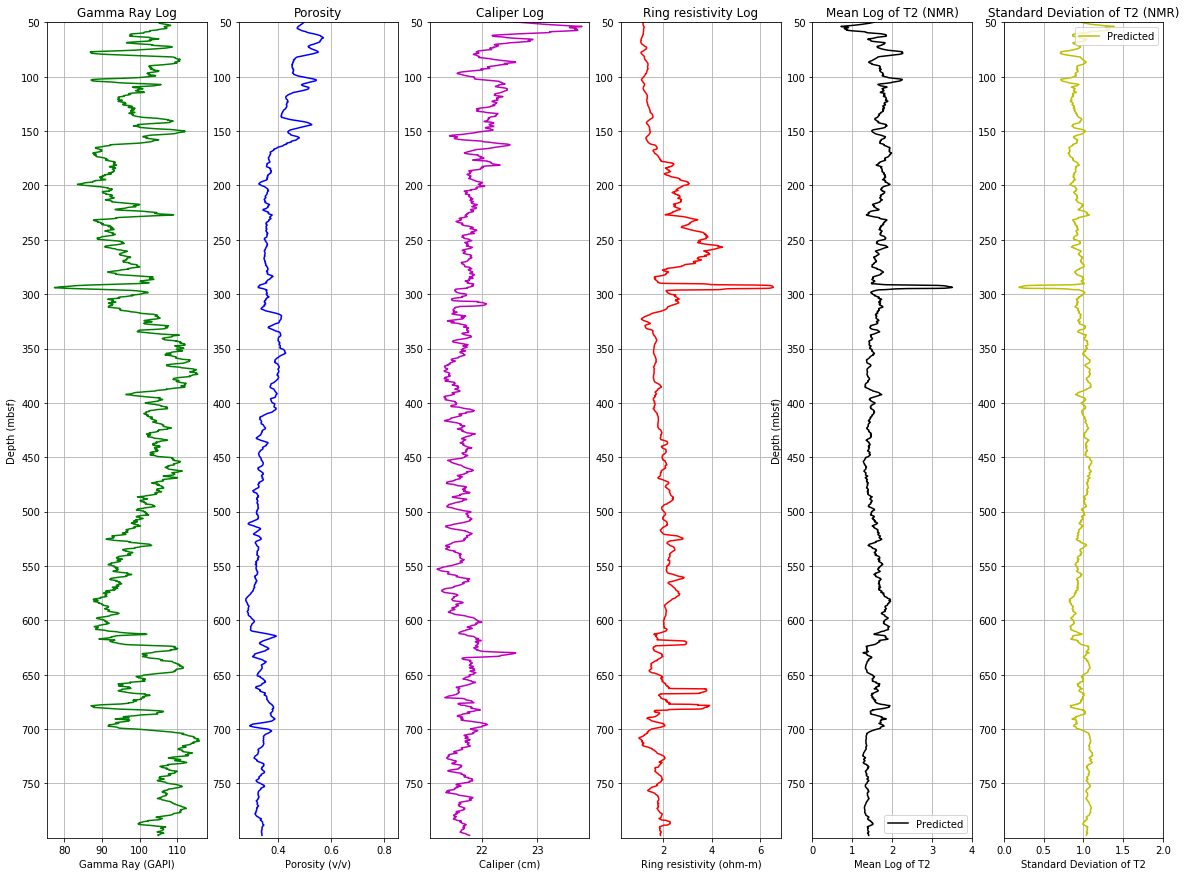

In [50]:
# Plot logs vs depth

plt.subplot(161)
plt.plot(df_WR['GR'].values, df_WR['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(162)
plt.plot(df_WR['Porosity'].values, df_WR['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(163)
plt.plot(df_WR['Caliper'].values, df_WR['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(164)
plt.plot(df_WR['Ring resistivity'].values, df_WR['Depth'].values,'r')
#plt.xscale('log')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(165)
plt.plot(MLT2_poly_pred_WR, dfS_WR['Depth'].values,'k',label='Predicted')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df_WR['Depth'].values), 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().set_xlim([0,4])
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(166)
plt.plot(SDT2_poly_pred_WR, dfS_WR['Depth'].values,'y',label='Predicted')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df_WR['Depth'].values), 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().set_xlim([0,2])
plt.gca().invert_yaxis()
plt.legend()

plt.gcf().set_size_inches(20, 15)

The predicted MLT2 and SDT2 from the regression model are plotted alongside the other logs. It can be seen that the behavior is in line with other logs, eg. at low GR ~290 mbsf, the MLT2 increases and SDT2 reduces. Hence, the MLT2 and SDT2 can be successfully predicted using the workflow. The model can be further improved with more data from other wells and exploring other methods.
